# Проект "Определение стоимости автомобилей"

### Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости

Заказчику важны:
- качество предсказания
- скорость предсказания
- время обучения

Примечания:
- обучить разные модели, одна из которых — LightGBM и как минимум одна — не бустинг
- для оценки качества моделей применять метрику RMSE (значение должно быть меньше 2500)

### Описание данных

Данные находятся в файле `/datasets/autos.csv`

Признаки
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак
- `Price` — цена (евро)

### План действий

1. Загрузить, изучить и подготовить данные
2. Подготовить выборки, обучить разные модели машинного обучения (градиентный бустинг и модели попроще), для каждой подобрать оптимальные гиперпараметры
3. Проанализировать время обучения, время предсказания и качество моделей, выбрать лучшую модель и проверить её качество на тестовой выборке

<br><br><br><br>

# 1. Подготовка данных

Импортируем необходимые для работы модули:

In [1]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings

Настроим параметры и функции вывода на экран:

In [2]:
# настройки вывода датафреймов
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)

# отключаем предупреждения
warnings.filterwarnings('ignore')

In [3]:
# зададим жирный шрифт и цвет вывода при помощи ANSI escape sequences
reset = '\033[0m'
bold = reset + '\033[1m'
color_bold = reset + '\033[1;94m'

In [4]:
# функция вывода цветного заголовка (bold, blue) с линиями сверху и снизу
def head_print(text, linesize=None):
    linesize = linesize or len(text)
    line = '—' * linesize
    print(color_bold + line)
    print(text)
    print(line + reset)

In [5]:
# переменная для фиксации сидов (параметр random_state=rnd)
rnd = 1

Загрузим данные из файла в датафрейм `df0` (исходные данные):

In [6]:
file_name = 'autos.csv'
for path in ['', 'data/', 'datasets/', '/datasets/']:
    if os.path.exists(path + file_name):
        break
else:
    path = 'https://code.s3.yandex.net/datasets/'
df0 = pd.read_csv(path + file_name)
print(f'Файл с данными "{color_bold + file_name + reset}" был найден и загружен по адресу:')
print(color_bold + path + file_name + reset)

Файл с данными "autos.csv" был найден и загружен по адресу:
/datasets/autos.csv


Выведем общую информацию о датафрейме `df0`, изучим данные:

In [7]:
head_print(f'В датафрейме "df0":    Строк: {df0.shape[0]}    Столбцов: {df0.shape[1]}')
print(color_bold + '\nПервые 5 строк:')
display(df0.head())
print('\n' + color_bold + 'Общая информация о столбцах:\n' + reset)
print(df0.info())
print('\n' + color_bold + 'Количество пропусков в столбцах:\n' + reset)
print(df0.isna().sum()[df0.isna().sum() > 0])
print('\n' + color_bold + 'Основные статистики для числовых признаков:' + reset)
display(df0.describe())

————————————————————————————————————————————————————
В датафрейме "df0":    Строк: 354369    Столбцов: 16
————————————————————————————————————————————————————

Первые 5 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Общая информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  o

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Итак, в датафрейме 354369 строк и 16 столбцов: 15 фичей-признаков и 1 целевой признак - цена автомобиля. Несколько столбцов можно удалить, как неинформативные. Видим, что в некоторых столбцах есть пропущенные данные и явные аномальные значения. План действий по подготовке и предобработке данных будет следующим:

Первым делом для удобства работы:
- Переименуем столбцы
- Удалим столбцы с данными, которые не будут использоваться в моделировании (неинформативные признаки)
- Заменим порядок следования столбцов на более удобочитаемый и логичный

Далее последовательно исследуем каждый столбец:
- Исправим или удалим аномальные значения
- Заменим пропущенные значения, если это возможно
- Исследуем строковые столбцы на наличие неявных дубликатов
- Преобразуем тип данных

Наконец, исследуем датафрейм на наличие явных дубликатов

<br><br>

## 1.1. Названия столбцов и структура датафрейма

Видим, что названия столбцов в датафрейме записаны в нотации 'PascalCase'. Напишем функцию преобразования нотации строки в 'snake_case', функцию замены названий столбцов и заменим названия столбцов в датафрейме:

In [8]:
# функция перевода нотации строки из 'PascalCase' в 'snake_case'
def to_snake_case(s):
    r = ''
    for i, c in enumerate(s):
        if c.isupper() and i and (s[i - 1].islower() or (i + 1 < len(s) and s[i + 1].islower())):
            r += '_'
        r += c.lower()
    return r

In [9]:
# функция замены названий столбцов датафрейма (по умолчанию с выводом результата)
def change_columns_names(df, show=True):
    if show:
        old_columns = df.columns
        # максимальная длина старого названия столбца (для динамического выравнивания вывода)
        column_max_len = len(sorted(old_columns, key=len)[-1])
    # переименовываем столбцы
    df.columns = [to_snake_case(column) for column in df.columns]
    # заменим некоторые названия столбцов на более короткие и ёмкие
    df.rename(columns={'vehicle_type': 'type', 
                       'registration_year': 'year', 
                       'fuel_type': 'fuel'}, inplace=True)
    if show:
        # выводим на экран результат переименования
        for old_column, new_column in zip(old_columns, df.columns):
            print(f"{old_column}{' ' * (column_max_len - len(old_column))}  -->  {new_column}")
        print()

In [10]:
show = 1  # выводить на экран результат переименования (1), или нет (0)
if show:
    head_print(f'Переименовываем столбцы:', 60)
change_columns_names(df0, show)

————————————————————————————————————————————————————————————
Переименовываем столбцы:
————————————————————————————————————————————————————————————
DateCrawled        -->  date_crawled
Price              -->  price
VehicleType        -->  type
RegistrationYear   -->  year
Gearbox            -->  gearbox
Power              -->  power
Model              -->  model
Kilometer          -->  kilometer
RegistrationMonth  -->  registration_month
FuelType           -->  fuel
Brand              -->  brand
Repaired           -->  repaired
DateCreated        -->  date_created
NumberOfPictures   -->  number_of_pictures
PostalCode         -->  postal_code
LastSeen           -->  last_seen



На наш целевой признак - цену автомобиля (столбец `price`) - очевидно влияют:
- марка автомобиля (столбцы `brand` и `model`)
- год выпуска (`year`)
- тип кузова (`type`)
- тип топлива, коробки передач и мощность двигателя (`fuel`, `gearbox`, `power`)
- пробег (`kilometer`)
- а также была ли машина в ремонте (`repaired`)

Столбцы `registration_month`, `number_of_pictures`, `postal_code`, `date_created`, `date_crawled`, `last_seen` не несут какой-либо полезной информации, влияющей на предсказание цены - являются неинформативными признаками, их можно удалить:

In [11]:
column_order = ['brand', 'model', 'year', 'type', 'fuel', 'gearbox', 'power', 'kilometer', 'repaired', 'price']
df = df0[column_order]

Выведем общую информацию о датафрейме `df`:

In [12]:
head_print(f'В датафрейме "df":    Строк: {df.shape[0]}    Столбцов: {df.shape[1]}')
print(color_bold + '\nПервые 5 строк:')
display(df.head())
print('\n' + color_bold + 'Общая информация о столбцах:\n' + reset)
print(df.info())
print('\n' + color_bold + 'Количество пропусков в столбцах:\n' + reset)
print(df.isna().sum()[df.isna().sum() > 0])
print('\n' + color_bold + 'Основные статистики для числовых признаков:' + reset)
display(df.describe())

———————————————————————————————————————————————————
В датафрейме "df":    Строк: 354369    Столбцов: 10
———————————————————————————————————————————————————

Первые 5 строк:


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired,price
0,volkswagen,golf,1993,NaN,petrol,manual,0,150000,NaN,480
1,audi,NaN,2011,coupe,gasoline,manual,190,125000,yes,18300
2,jeep,grand,2004,suv,gasoline,auto,163,125000,NaN,9800
3,volkswagen,golf,2001,small,petrol,manual,75,150000,no,1500
4,skoda,fabia,2008,small,gasoline,manual,69,90000,no,3600



Общая информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   brand      354369 non-null  object
 1   model      334664 non-null  object
 2   year       354369 non-null  int64 
 3   type       316879 non-null  object
 4   fuel       321474 non-null  object
 5   gearbox    334536 non-null  object
 6   power      354369 non-null  int64 
 7   kilometer  354369 non-null  int64 
 8   repaired   283215 non-null  object
 9   price      354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB
None

Количество пропусков в столбцах:

model       19705
type        37490
fuel        32895
gearbox     19833
repaired    71154
dtype: int64

Основные статистики для числовых признаков:


,year,power,kilometer,price
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,2004.234448,110.094337,128211.172535,4416.656776
std,90.227958,189.850405,37905.341530,4514.158514
min,1000.000000,0.000000,5000.000000,0.000000
25%,1999.000000,69.000000,125000.000000,1050.000000
50%,2003.000000,105.000000,150000.000000,2700.000000
75%,2008.000000,143.000000,150000.000000,6400.000000
max,9999.000000,20000.000000,150000.000000,20000.000000


<br><br>

## 1.2. Столбец `brand`

Тип данных строковый. Пропусков нет

Выведем уникальные значения:

In [13]:
print(color_bold + 'Количество объявлений по автомобильным маркам:' + reset)
df['brand'].value_counts().sort_index()

Количество объявлений по автомобильным маркам:


alfa_romeo         2314
audi              29456
bmw               36914
chevrolet          1754
chrysler           1439
citroen            5148
dacia               900
daewoo              542
daihatsu            806
fiat               9643
ford              25179
honda              2817
hyundai            3587
jaguar              505
jeep                677
kia                2465
lada                225
lancia              471
land_rover          545
mazda              5615
mercedes_benz     32046
mini               3202
mitsubishi         3022
nissan             4941
opel              39931
peugeot           10998
porsche             758
renault           17927
rover               486
saab                526
seat               6907
skoda              5500
smart              5246
sonstige_autos     3374
subaru              762
suzuki             2323
toyota             4606
trabant             589
volkswagen        77013
volvo              3210
Name: brand, dtype: int64

Аномальных значений и неявных дубликатов не обнаружено

Визуализируем ТОП-10 автомобильных марок:

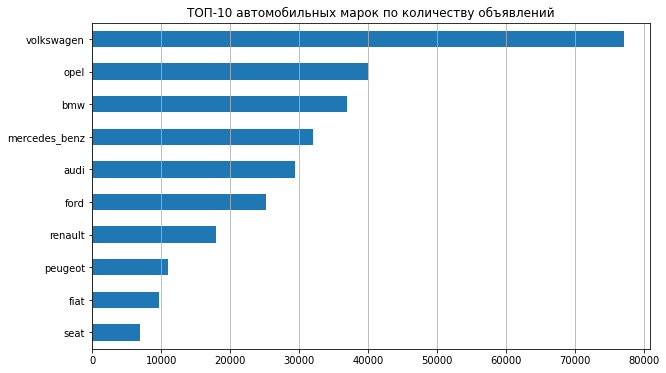

In [14]:
df['brand'].value_counts(ascending=True).tail(10).plot(kind='barh', figsize=(10, 6))
plt.title('ТОП-10 автомобильных марок по количеству объявлений')
plt.grid(axis='x')
plt.show()

По количеству размещённых объявлений с большим отрывом лидирует марка автомобиля **Volkswagen**

<br><br>

## 1.3. Столбец `model`

Тип данных строковый. В столбце 19705 пропущенных значений

Выведем уникальные значения:

In [15]:
print(color_bold + 'Список моделей автомобилей:\n' + reset)
print(", ".join(sorted(df['model'].fillna('#NA').unique())))

Список моделей автомобилей:

#NA, 100, 145, 147, 156, 159, 1_reihe, 1er, 200, 2_reihe, 300c, 3_reihe, 3er, 4_reihe, 500, 5_reihe, 5er, 601, 6_reihe, 6er, 7er, 80, 850, 90, 900, 9000, 911, a1, a2, a3, a4, a5, a6, a8, a_klasse, accord, agila, alhambra, almera, altea, amarok, antara, arosa, astra, auris, avensis, aveo, aygo, b_klasse, b_max, beetle, berlingo, bora, boxster, bravo, c1, c2, c3, c4, c5, c_klasse, c_max, c_reihe, caddy, calibra, captiva, carisma, carnival, cayenne, cc, ceed, charade, cherokee, citigo, civic, cl, clio, clk, clubman, colt, combo, cooper, cordoba, corolla, corsa, cr_reihe, croma, crossfire, cuore, cx_reihe, defender, delta, discovery, doblo, ducato, duster, e_klasse, elefantino, eos, escort, espace, exeo, fabia, fiesta, focus, forester, forfour, fortwo, fox, freelander, fusion, g_klasse, galant, galaxy, getz, gl, glk, golf, grand, i3, i_reihe, ibiza, impreza, insignia, jazz, jetta, jimny, juke, justy, ka, kadett, kaefer, kalina, kalos, kangoo, kappa, kuga, lagun

Каких-то аномалий на первый взгляд не выявлено, как и неявных дубликатов

Рассмотрим, что представляет из себя модельный ряд каждой автомобильной марки, какого он размера и по сколько записей имеется в датафрейме для каждой модели:

In [16]:
print(color_bold + 'Модельный ряд и количество автомобилей каждой модели:\n' + reset)
df.groupby(['brand', 'model'])['price'].count()

Модельный ряд и количество автомобилей каждой модели:



brand          model             
alfa_romeo     145                      49
               147                     572
               156                     629
               159                     212
               other                   521
               spider                  194
audi           100                     417
               200                      18
               80                     1604
               90                      103
               a1                      595
               a2                      373
               a3                     6122
               a4                     9900
               a5                      545
               a6                     5541
               a8                      529
               other                  1033
               q3                       15
               q5                       97
               q7                      205
               tt                     1076
bmw            1er  

Обратим внимание, что практически для каждой марки автомобиля модельный ряд неполный. Вероятно отражены самые популярные модели, а остальные (влючая, возможно, и те, по которым не было информации от продавца) - обозначены моделью "other"

Визуализируем ТОП-10 автомобильных марок:

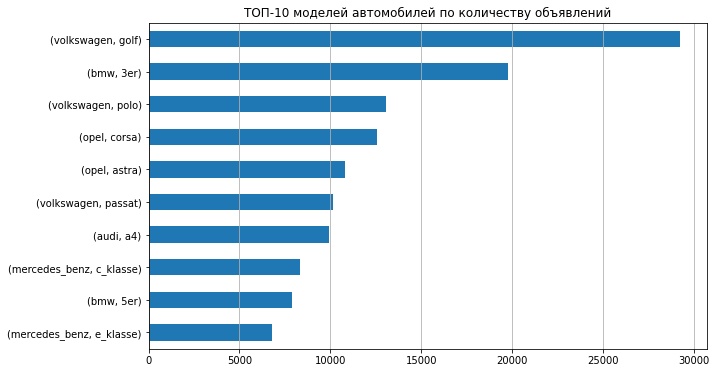

In [17]:
df.groupby(['brand', 'model'])['price'].count().sort_values().tail(10).plot(kind='barh', figsize=(10, 6))
plt.title('ТОП-10 моделей автомобилей по количеству объявлений')
plt.grid(axis='x')
plt.ylabel('')
plt.show()

По количеству размещённых объявлений самый продаваемый автомобиль **Volkswagen Golf**

Исследуем пропуски. Выведем первые 10 записей с пропусками в столбце `model`, посмотрим на них внимательней:

In [18]:
print(color_bold + 'Пропуски в столбце "model", первые 10 строк:' + reset)
df.loc[df['model'].isna()].head(10)

Пропуски в столбце "model", первые 10 строк:


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired,price
1,audi,NaN,2011,coupe,gasoline,manual,190,125000,yes,18300
59,sonstige_autos,NaN,1994,suv,NaN,manual,286,150000,NaN,1
81,fiat,NaN,1997,small,NaN,manual,54,150000,yes,350
115,volkswagen,NaN,1999,small,petrol,NaN,0,5000,NaN,0
135,audi,NaN,1992,sedan,NaN,manual,136,150000,no,1450
151,volkswagen,NaN,2009,small,petrol,NaN,60,20000,no,6799
160,renault,NaN,1999,small,petrol,manual,0,150000,no,500
161,volkswagen,NaN,2001,wagon,gasoline,NaN,64,150000,NaN,1495
186,bmw,NaN,2008,sedan,NaN,NaN,235,150000,no,14000
193,volkswagen,NaN,1990,coupe,petrol,manual,45,150000,NaN,1200


Заполнять пропуски в этом столбце самой часто встречающейся моделью данной марки было бы неправильно и совершенно необоснованно. На месте пропусков может оказаться любая модель из модельного ряда. Удалять же столько записей (почти 20 тысяч) также не хотелось бы

Попытаемся определить модель автомобиля по остальным признакам. Возможно, конкретному набору признаков соответствуют только определённая модель, что позволит заполнить пропуски в этом столбце

Сгруппируем данные по марке автомобиля, типу кузова, топлива и коробки передач. Выведем для каждой группы количество записей, сколько записей с пропусками в столбце `model`, а также перечень моделей. Пропуски обозначим "#NA". Для примера выведем таблицу только для марки alfa_romeo:

In [19]:
print(color_bold + 'Группировка по марке автомобиля, типу кузова, топлива и коробки передач:' + reset)
display(df.loc[df['brand'] == 'alfa_romeo']
        .groupby(['brand', 'type', 'fuel', 'gearbox'])['model']
        .agg(['size', lambda x: x.size - x.count(), lambda x: ', '.join(x.fillna('#NA').unique())])
        .rename(columns={'size': 'Объектов в группе', '<lambda_0>': 'Из них с пропусками', '<lambda_1>': 'Модели'}))

Группировка по марке автомобиля, типу кузова, топлива и коробки передач:


Объектов в группе  \
brand      type        fuel     gearbox                      
alfa_romeo convertible gasoline auto                     1   
                                manual                   9   
                       lpg      manual                   1   
                       petrol   auto                     1   
                                manual                 155   
           coupe       gasoline manual                  63   
                       lpg      manual                   1   
                       petrol   auto                    11   
                                manual                 138   
           other       gasoline manual                   3   
                       petrol   auto                     2   
                                manual                   8   
           sedan       gasoline auto                     4   
                                manual                 209   
                       lpg      auto                     1   
                                manual                  15   
                       petrol   auto                    43   
                                manual                 604   
           small       gasoline manual                  33   
                       lpg      manual                   2   
                       petrol   auto                    18   
                                manual                 176   
           wagon       gasoline auto                    20   
                                manual                 237   
                       lpg      auto                     1   
                                manual                   8   
                       petrol   auto                    23   
                                manual                 143   

                                         Из них с пропусками  \
brand      type        fuel     gearbox                        
alfa_romeo convertible gasoline auto                       0   
                                manual                     0   
                       lpg      manual                     0   
                       petrol   auto                       0   
                                manual                     0   
           coupe       gasoline manual                     2   
                       lpg      manual                     0   
                       petrol   auto                       0   
                                manual                     8   
           other       gasoline manual                     1   
                       petrol   auto                       0   
                                manual                     0   
           sedan       gasoline auto                       0   
                                manual                     9   
                       lpg      auto                       0   
                                manual                     0   
                       petrol   auto                       1   
                                manual                    16   
           small       gasoline manual                     0   
                       lpg      manual                     0   
                       petrol   auto                       0   
                                manual                     3   
           wagon       gasoline auto                       0   
                                manual                     3   
                       lpg      auto                       0   
                                manual                     0   
                       petrol   auto                       2   
                                manual                     4   

                                                                         Модели  
brand      type        fuel     gearbox                                          
alfa_romeo convertible gasoline auto                                     spider  
             

Видно, что вариативности признаков в данном случае недостаточно, чтобы чётко определить принадлежность той или иной модели автомобиля к конкретной группе. В каждой группе свой модельный ряд и количество моделей также разное, поэтому мы не можем точно определить, какой именно модели соответствует пропущенное значение

Однако, видим также, что практически в каждой группе, где есть пропуски по модели авто, среди модельного ряда встречается значение "other" (другая модель). Поэтому, за неимением другой информации, позволившей бы точно определить модель автомобиля, и чтобы не терять почти 20 тысяч строк, заполним пропуски значением "other":

In [20]:
print(color_bold + f"Заменено пропусков в столбце \"model\": {df['model'].isna().sum()}" + reset)
df.loc[df['model'].isna(), 'model'] = 'other'

Заменено пропусков в столбце "model": 19705


In [21]:
print(color_bold + 'Количество пропусков в столбцах на текущий момент:\n' + reset)
print(df.isna().sum()[df.isna().sum() > 0])

Количество пропусков в столбцах на текущий момент:

type        37490
fuel        32895
gearbox     19833
repaired    71154
dtype: int64


<br><br>

## 1.4. Столбец `year`

Тип данных целочисленный. Пропущенных значений нет

Выведем уникальные значения:

In [22]:
print(color_bold + 'Список годов выпуска:\n' + reset)
print(sorted(df['year'].unique()))

Список годов выпуска:

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


В столбце много аномальных значений. Посмотрим на распределение признака:

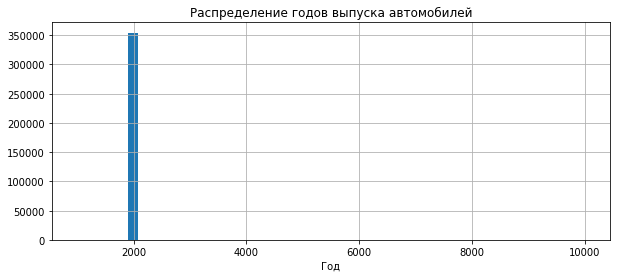

In [23]:
df['year'].hist(bins=50, figsize=(10, 4))
plt.title('Распределение годов выпуска автомобилей')
plt.xlabel('Год')
plt.show()

Видим, что даты сосредоточены в районе 2000 года. Выведем гистограмму в границах 1970-2020гг:

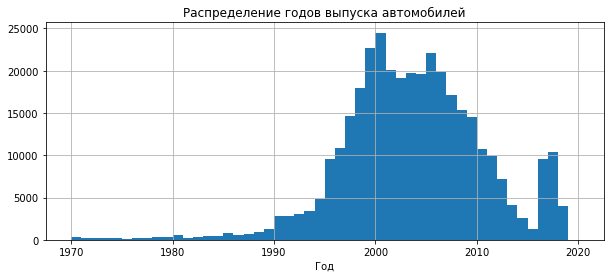

In [24]:
df['year'].hist(bins=50, figsize=(10, 4), range=(1970, 2020))
plt.title('Распределение годов выпуска автомобилей')
plt.xlabel('Год')
plt.show()

Год выпуска обычно сильно влияет на стоимость автомобиля, поэтому от нужно избавиться от аномальных значений. Восстановить реальный год выпуска на этих данных не представляется возможным, т.к. одни и те же модели автомобилей с одинаковыми характеристиками производились обычно несколько лет подряд. Поэтому остаётся только удалить записи с машинами старше, скажем, 1970 года и те, где дата выпуска превышает дату подачи объявления о продаже:

In [25]:
# преобразуем строковую дату в формат даты и выделим отдельно год и месяц создания объявления
date_created = pd.to_datetime(df0['date_created'], format='%Y-%m-%d %H:%M:%S')
year_created = date_created.dt.year
month_created = date_created.dt.month

# индексы записей с правильной датой выпуска автомобиля
good_date_index = df0.query(
    'year >= 1970 and (year < @year_created or (year == @year_created and registration_month < @month_created))'
).index

good_date_index = [idx for idx in good_date_index if idx in df.index]
df_size = df.shape[0]

# удаляем записи с неправильной датой
df = df.loc[good_date_index]

print(color_bold + f'Удалено записей: {df_size - len(good_date_index)},   Осталось: {df.shape[0]}' + reset)

Удалено записей: 21777,   Осталось: 332592


In [26]:
print(color_bold + 'Количество пропусков в столбцах на текущий момент:\n' + reset)
print(df.isna().sum()[df.isna().sum() > 0])

Количество пропусков в столбцах на текущий момент:

type        16905
fuel        24609
gearbox     17038
repaired    61894
dtype: int64


Итоговое распределение годов выпуска автомобилей:

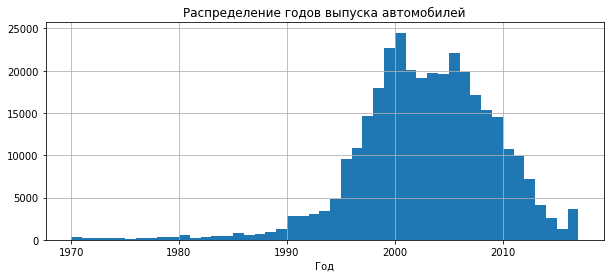

In [27]:
df['year'].hist(bins=47, figsize=(10, 4), range=(1970, 2017))
plt.title('Распределение годов выпуска автомобилей')
plt.xlabel('Год')
plt.show()

<br><br>

## 1.5. Столбец `type`

Тип данных строковый. В столбце 16905 пропущенных значений

Выведем уникальные значения:

In [28]:
print(color_bold + 'Количество объявлений по типам кузова автомобилей:\n' + reset)
print(df['type'].fillna('#NA').value_counts())

Количество объявлений по типам кузова автомобилей:

sedan          90999
small          79667
wagon          65114
bus            28738
convertible    20083
#NA            16905
coupe          15976
suv            11907
other           3203
Name: type, dtype: int64


Каких-то аномалий на первый взгляд не выявлено, как и неявных дубликатов

Исследуем пропуски. Выведем первые 10 записей с пропусками в столбце `type`, посмотрим на них внимательней:

In [29]:
print(color_bold + 'Пропуски в столбце "type", первые 10 строк:' + reset)
df.loc[df['type'].isna()].head(10)

Пропуски в столбце "type", первые 10 строк:


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired,price
0,volkswagen,golf,1993,NaN,petrol,manual,0,150000,NaN,480
16,volkswagen,polo,2016,NaN,petrol,NaN,60,150000,NaN,300
37,renault,kangoo,2016,NaN,gasoline,NaN,0,150000,no,1500
40,opel,corsa,1990,NaN,petrol,NaN,0,150000,NaN,0
52,hyundai,other,2016,NaN,NaN,manual,55,5000,NaN,1400
71,bmw,5er,1997,NaN,NaN,manual,150,150000,no,2300
77,volkswagen,golf,2000,NaN,gasoline,manual,90,150000,NaN,800
92,ford,ka,2000,NaN,NaN,NaN,60,150000,NaN,250
94,opel,insignia,2009,NaN,NaN,NaN,0,150000,NaN,8390
107,honda,civic,1995,NaN,petrol,manual,90,150000,NaN,900


Удалять почти 17 тысяч записей не хотелось бы. Попытаемся определить тип кузова по остальным признакам. Возможно, конкретному набору признаков соответствуют только определённый тип кузова, что позволит заполнить пропуски в этом столбце

Сгруппируем данные по марке и модели автомобиля, типу топлива и коробки передач. Выведем для каждой группы количество записей, количество записей с пропусками в столбце `type`, а также перечень типов кузова. Пропуски обозначим "#NA". Для примера выведем таблицу только для марки citroen:

In [30]:
print(color_bold + 'Группировка по марке и модели автомобиля, типу топлива и коробки передач:' + reset)
display(df.loc[df['brand'] == 'citroen']
        .groupby(['brand', 'model', 'fuel', 'gearbox'])['type']
        .agg(['size', lambda x: x.size - x.count(), lambda x: ', '.join(x.fillna('#NA').unique())])
        .rename(columns={'size': 'Объектов в группе', '<lambda_0>': 'Из них с пропусками', '<lambda_1>': 'Модели'}))

Группировка по марке и модели автомобиля, типу топлива и коробки передач:


Объектов в группе  Из них с пропусками  \
brand   model    fuel     gearbox                                           
citroen berlingo cng      manual                   5                    0   
                 gasoline auto                    13                    0   
                          manual                 313                    4   
                 lpg      manual                  13                    1   
                 petrol   auto                     1                    0   
                          manual                 356                   13   
        c1       gasoline manual                  10                    0   
                 lpg      manual                   1                    0   
                 petrol   auto                    25                    0   
                          manual                 321                    1   
        c2       gasoline auto                     9                    0   
                          manual                  57                    0   
                 lpg      auto                     2                    0   
                          manual                   2                    0   
                 petrol   auto                    23                    0   
                          manual                 245                    2   
        c3       gasoline auto                    13                    0   
                          manual                  79                    0   
                 lpg      auto                     1                    0   
                          manual                   5                    0   
                 petrol   auto                    39                    0   
                          manual                 317                    5   
        c4       gasoline auto                    72                    0   
                          manual                 139                    1   
                 lpg      auto                     4                    0   
                          manual                   4                    0   
                 petrol   auto                    26                    0   
                          manual                 158                    0   
        c5       cng      manual                   1                    0   
                 electric manual                   1                    0   
                 gasoline auto                   121                    1   
                          manual                 183                    0   
                 lpg      auto                     4                    0   
                          manual                   3                    0   
                 petrol   auto                    46                    0   
                          manual                  92                    1   
        other    electric auto                     1                    0   
                 gasoline auto                    49                    1   
                          manual                 447                   11   
                 lpg      auto                     7                    0   
                          manual                  23                    0   
                 other    manual                   1                    0   
                 petrol   auto                    92                    4   
                          manual                1061                   35   

                                                                                          Модели  
brand   model    fuel     gearbox                                                                 
citroen berlingo cng      manual                                                      bus, wagon  
                 gasoline auto                                                 bus, wagon, other  
                          manual                            bus, other, wagon, #NA, small, sedan

Видно, что в каждой группе, как правило, присутствует несколько типов кузова, поэтому в данном случае мы не можем точно определить, какому именно типу кузова соответствует пропущенное значение

Заполним пропуски в столбце `type` значением "undefined":

In [31]:
print(color_bold + f"Заменено пропусков в столбце \"type\": {df['type'].isna().sum()}" + reset)
df.loc[df['type'].isna(), 'type'] = 'undefined'

Заменено пропусков в столбце "type": 16905


In [32]:
print(color_bold + 'Количество пропусков в столбцах на текущий момент:\n' + reset)
print(df.isna().sum()[df.isna().sum() > 0])

Количество пропусков в столбцах на текущий момент:

fuel        24609
gearbox     17038
repaired    61894
dtype: int64


<br><br>

## 1.6. Столбец `fuel`

Тип данных строковый. В столбце 24609 пропущенных значений

Выведем уникальные значения:

In [33]:
print(color_bold + 'Количество объявлений по типам топлива автомобилей:\n' + reset)
print(df['fuel'].fillna('#NA').value_counts())

Количество объявлений по типам топлива автомобилей:

petrol      206427
gasoline     95444
#NA          24609
lpg           5097
cng            532
hybrid         218
other          178
electric        87
Name: fuel, dtype: int64


Каких-то аномалий на первый взгляд не выявлено, как и неявных дубликатов

Исследуем пропуски. Выведем первые 10 записей с пропусками в столбце `fuel`, посмотрим на них внимательней:

In [34]:
print(color_bold + 'Пропуски в столбце "fuel", первые 10 строк:' + reset)
df.loc[df['fuel'].isna()].head(10)

Пропуски в столбце "fuel", первые 10 строк:


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired,price
9,volkswagen,golf,1998,small,NaN,manual,101,150000,NaN,999
13,volkswagen,passat,2004,wagon,NaN,manual,131,150000,no,2500
36,opel,kadett,1991,other,NaN,manual,75,70000,NaN,1600
41,mercedes_benz,e_klasse,2002,sedan,NaN,auto,306,150000,NaN,7500
52,hyundai,other,2016,undefined,NaN,manual,55,5000,NaN,1400
54,opel,signum,2005,wagon,NaN,manual,0,150000,no,4700
59,sonstige_autos,other,1994,suv,NaN,manual,286,150000,NaN,1
69,opel,astra,2001,coupe,NaN,NaN,0,150000,NaN,1200
71,bmw,5er,1997,undefined,NaN,manual,150,150000,no,2300
81,fiat,other,1997,small,NaN,manual,54,150000,yes,350


Очевидно, что по остальным признакам определить вид топлива не удастся, так как в любой модели автомобиля с любым типом кузова и коробки передач может быть установлен как бензиновый, так и дизельный двигатель (или гибрид, или двигатели на других видах топлива). Но и удалять почти 25 тысяч записей не хотелось бы

Заполним пропуски в столбце `fuel` значением "undefined":

In [35]:
print(color_bold + f"Заменено пропусков в столбце \"fuel\": {df['fuel'].isna().sum()}" + reset)
df.loc[df['fuel'].isna(), 'fuel'] = 'undefined'

Заменено пропусков в столбце "fuel": 24609


In [36]:
print(color_bold + 'Количество пропусков в столбцах на текущий момент:\n' + reset)
print(df.isna().sum()[df.isna().sum() > 0])

Количество пропусков в столбцах на текущий момент:

gearbox     17038
repaired    61894
dtype: int64


<br><br>

## 1.7. Столбец `gearbox`

Тип данных строковый. В столбце 17038 пропущенных значений

Выведем уникальные значения:

In [37]:
print(color_bold + 'Количество объявлений по типам коробки передач автомобилей:\n' + reset)
print(df['gearbox'].fillna('#NA').value_counts())

Количество объявлений по типам коробки передач автомобилей:

manual    252112
auto       63442
#NA        17038
Name: gearbox, dtype: int64


Каких-то аномалий на первый взгляд не выявлено, как и неявных дубликатов. Автомобилей с механической коробкой передач продается в 4 раза больше, чем с автоматической

Исследуем пропуски. Выведем первые 10 записей с пропусками в столбце `gearbox`, посмотрим на них внимательней:

In [38]:
print(color_bold + 'Пропуски в столбце "gearbox", первые 10 строк:' + reset)
df.loc[df['gearbox'].isna()].head(10)

Пропуски в столбце "gearbox", первые 10 строк:


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired,price
16,volkswagen,polo,2016,undefined,petrol,NaN,60,150000,NaN,300
32,volkswagen,golf,1994,sedan,petrol,NaN,0,150000,no,245
37,renault,kangoo,2016,undefined,gasoline,NaN,0,150000,no,1500
40,opel,corsa,1990,undefined,petrol,NaN,0,150000,NaN,0
69,opel,astra,2001,coupe,undefined,NaN,0,150000,NaN,1200
92,ford,ka,2000,undefined,undefined,NaN,60,150000,NaN,250
94,opel,insignia,2009,undefined,undefined,NaN,0,150000,NaN,8390
110,opel,corsa,1998,small,petrol,NaN,0,150000,NaN,350
115,volkswagen,other,1999,small,petrol,NaN,0,5000,NaN,0
130,bmw,3er,2000,undefined,undefined,NaN,0,150000,NaN,3390


Очевидно, что по остальным признакам определить тип коробки передач не удастся, так как в любой модели автомобиля с любым типом кузова и топлива может быть установлена как механическая, так и автоматическая коробка передач. Удалять 17 тысяч записей не хотелось бы

Заполним пропуски в столбце `gearbox` значением "undefined":

In [39]:
print(color_bold + f"Заменено пропусков в столбце \"gearbox\": {df['gearbox'].isna().sum()}" + reset)
df.loc[df['gearbox'].isna(), 'gearbox'] = 'undefined'

Заменено пропусков в столбце "gearbox": 17038


In [40]:
print(color_bold + 'Количество пропусков в столбцах на текущий момент:\n' + reset)
print(df.isna().sum()[df.isna().sum() > 0])

Количество пропусков в столбцах на текущий момент:

repaired    61894
dtype: int64


<br><br>

## 1.8. Столбец `power`

Тип данных целочисленный. Пропущенных значений нет

Выведем уникальные значения и построим гистограмму исходного распределения мощностей автомобилей:

In [41]:
print(color_bold + 'Список значений мощности двигателя:\n' + reset)
print(sorted(df['power'].unique()))

Список значений мощности двигателя:

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 21

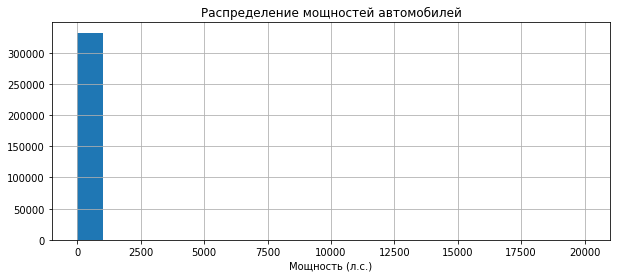

In [42]:
df['power'].hist(bins=20, figsize=(10, 4))
plt.title('Распределение мощностей автомобилей')
plt.xlabel('Мощность (л.с.)')
plt.show()

Детализируем график в реальных границах значений мощности:

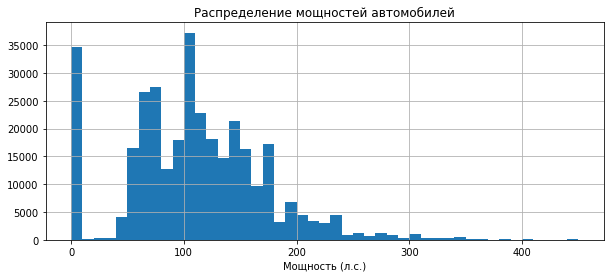

In [43]:
df['power'].hist(bins=45, figsize=(10, 4), range=(0, 450))
plt.title('Распределение мощностей автомобилей')
plt.xlabel('Мощность (л.с.)')
plt.show()

Видим, что в столбце `power` много аномальных значений - помимо нереально высоких значений (которых не так много), есть также заметный выброс на гистограмме с нулевыми значениями. Заменим аномальное значение мощности для каждого автомобиля на среднее значение мощности группы автомобилей, максимально похожих на него по параметрам. Разработаем следующий алгоритм:

1. Определим нижнюю и верхнюю допустимую границы мощности двигателя. разобьём датафрейм на две выборки - выборку "А" - эталонную, в которой значения мощности двигателя не выходят за установленные границы, и выборку "В" - рабочую, в которой требуется заменить аномально большие или маленькие значения мощности двигателя
2. Выборку "А" сгруппируем по подробному списку из 6 параметров - марке и модели автомобиля, типу топлива, коробки передач, году выпуска и типу кузува - и вычислим среднюю мощность для каждой получившейся группы
3. Далее в цикле пройдёмся по всем автомобилям из выборки "В" (с аномальными значениями мощности), найдём автомобиль с такими же параметрами в сгруппированной таблице выборки "А" и присвоим ему вычисленную среднюю мощность
4. Если детализация группы из выборки "А" окажется слишком высокой для какого-либо автомобиля из выборки "В", то будем снижать уровень детализации, убирая по одному параметру с конца списка (сначала уберем тип кузова из списка параметров для группировки, если этого также будет недостаточно, уберём год выпуска и т.д., вплоть до группировки лишь по марке автомобиля, пока автомобиль из выборки "В" не будет найден в сгруппированной таблице выборки "А"):

In [44]:
# допустимые границы мощности
pmin = 10
pmax = 450

# индексы выборок "А" и "В"
indexes_a = df.loc[(df['power'] >= pmin) & (df['power'] <= pmax)].index
indexes_b = df.loc[(df['power'] < pmin) | (df['power'] > pmax)].index

# эталонная выборка "А"
dfa = df.loc[indexes_a]

# список параметров для группировки
match_columns = ['brand', 'model', 'fuel', 'gearbox', 'year', 'type']

# создадим сгруппированные таблицы с разной степенью группировки со средними мощностями автомобилей
multiindex = match_columns.copy()
groups = []
for i in range(6):
    groups.append(dfa.groupby(multiindex)['power'].mean())
    multiindex.pop()

In [45]:
%%time

# цикл по автомобилям из выборки "В"
for i in indexes_b:
    params = tuple(df.loc[i, match_columns])
    for group in groups:
        try:
            power = group[params] if len(params) > 1 else group[params[0]]
        except KeyError:
            params = tuple(list(params)[:-1])
            continue
        break
    df.loc[i, 'power'] = int(round(power))

CPU times: user 58.6 s, sys: 100 ms, total: 58.7 s
Wall time: 58.8 s


In [46]:
print(color_bold + f"Заменено аномальных значений в столбце \"power\": {len(indexes_b)}" + reset)

Заменено аномальных значений в столбце "power": 35201


Посмотрим на получившееся распределение мощностей автомобилей:

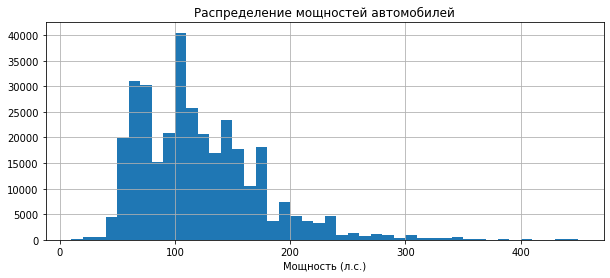

In [47]:
df['power'].hist(bins=44, figsize=(10, 4))
plt.title('Распределение мощностей автомобилей')
plt.xlabel('Мощность (л.с.)')
plt.show()

Отлично, избавились от всех выбросов и аномальных значений

<br><br>

## 1.9. Столбец `kilometer`

Тип данных целочисленный. Пропущенных значений нет

Выведем уникальные значения и построим гистограмму распределения:

In [48]:
print(color_bold + 'Список значений пробега:\n' + reset)
print(df['kilometer'].value_counts())

Список значений пробега:

150000    222856
125000     34492
100000     14064
90000      10993
80000       9588
70000       8219
60000       7144
50000       5958
5000        5474
40000       4741
30000       4233
20000       3734
10000       1096
Name: kilometer, dtype: int64


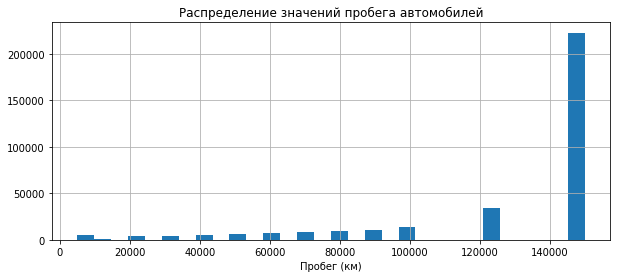

In [49]:
df['kilometer'].hist(bins=30, figsize=(10, 4))
plt.title('Распределение значений пробега автомобилей')
plt.xlabel('Пробег (км)')
plt.show()

Каких-либо аномалий не выявлено. В исходных данных очень много значений  150 тыс км. Видимо это связано с каким-то ограничением на сайте-плтформе сервиса по продаже автомобилей

<br><br>

## 1.10. Столбец `repaired`

Тип данных строковый. В столбце 61894 пропущенных значений

Выведем уникальные значения:

In [50]:
print(color_bold + 'Количество объявлений по признаку "repaired":\n' + reset)
print(df['repaired'].fillna('#NA').value_counts())

Количество объявлений по признаку "repaired":

no     236676
#NA     61894
yes     34022
Name: repaired, dtype: int64


Каких-то аномалий и неявных дубликатов не выявлено. В основном продаются автомобили, которые не были в ремонте. Логично предположить, что автомобили, у которых данный параметр не заполнялся пользователями (продавцами), также не были в ремонте

Заменим пропуски на значение "no":

In [51]:
print(color_bold + f"Заменено пропусков в столбце \"repaired\": {df['repaired'].isna().sum()}" + reset)
df['repaired'].fillna('no', inplace=True)

Заменено пропусков в столбце "repaired": 61894


Столбец `repaired` - это бинарный признак. Заменим значения "yes" на единицу, а "no" - на ноль и преобразуем тип в целочисленный:

In [52]:
df['repaired'] = df['repaired'].apply(lambda x: 1 if x == 1 or x == 'yes' else 0).astype('int')

In [53]:
print(color_bold + 'Количество пропусков во всех столбцах на текущий момент:\n' + reset)
print(df.isna().sum())

Количество пропусков во всех столбцах на текущий момент:

brand        0
model        0
year         0
type         0
fuel         0
gearbox      0
power        0
kilometer    0
repaired     0
price        0
dtype: int64


Отлично, с пропусками разобрались

<br><br>

## 1.11. Столбец `price`

Тип данных целочисленный. Пропущенных значений нет

Выведем уникальные значения цен с соответствующими им количествами записей:

In [54]:
print(color_bold + 'Список значений цен на автомобили и количество записей:\n' + reset)
print(df['price'].value_counts().sort_index())

Список значений цен на автомобили и количество записей:

0        9567
1        1057
2          10
3           7
4           1
         ... 
19995      10
19997       1
19998       6
19999     270
20000     254
Name: price, Length: 3680, dtype: int64


Максимальные цены в датафрейме - около 20 тысяч евро - хоть и высокие, но не запредельно, существуют и гораздо более дорогие  автомобили. Однако совсем низкие цены (около нуля) - это явные аномалии. Удалим из датафрейма записи с ценами менее 100 евро:

In [55]:
n_del = (df['price'] < 100).sum()
df = df.loc[df['price'] >= 100]
print(color_bold + f'Удалено записей: {n_del},   Осталось: {df.shape[0]}' + reset)

Удалено записей: 11900,   Осталось: 320692


Построим гистограмму распределения цен автомобилей:

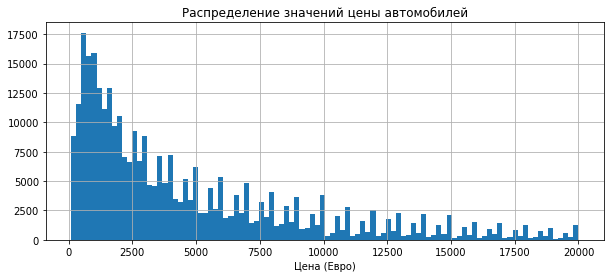

In [56]:
df['price'].hist(bins=100, figsize=(10, 4))
plt.title('Распределение значений цены автомобилей')
plt.xlabel('Цена (Евро)')
plt.show()

На гистограмме отчетливо видны периодические всплески значения цены - пики, соответствующие "круглым" ценам. Как правило, пики чуть повыше соответствуют ценам, округленным до тысяч (например, 5, 7, 10 тысяч евро и т.д.), а пики чуть пониже - ценам, округлённым до 500 евро (4.5, 5.5, 12.5 тысяч евро и т.д.)

Исследуем корреляцию признаков:

In [57]:
print(color_bold + 'Корреляция Пирсона' + reset)
df.corr().style.background_gradient(cmap='seismic', vmin=-1, vmax=1)

Корреляция Пирсона


,year,power,kilometer,repaired,price
year,1.000000,0.154668,-0.295805,-0.094867,0.532222
power,0.154668,1.000000,0.102083,-0.044879,0.510055
kilometer,-0.295805,0.102083,1.000000,0.071898,-0.362948
repaired,-0.094867,-0.044879,0.071898,1.000000,-0.188219
price,0.532222,0.510055,-0.362948,-0.188219,1.000000


Видно, что наш целевой признак - цена - имеет заметную прямую связь с годом выпуска и мощностью двигателя, умеренную обратную связь с пробегом и слабую обратную связь с фактом ремонта:

- Чем больше год выпуска (т.е., чем моложе автомобиль), тем выше цена (коэффициент корреляции Пирсона 0.53)
- Чем больше мощность, тем выше цена (к-т корреляции 0.51)
- Чем меньше километров пробега, тем выше цена (к-т корреляции -0.36)
- У признака `repaired` всего два состояния: 0 соответствует тому, что машина не была в ремонте (цена выше), а 1 - что ремонт проводился (цена ниже) (к-т корреляции -0.19)

Между остальными признаками связи либо почти нет, либо слабая, т.е. мультиколлинеарность отсутствует

<br><br>

## 1.12. Поиск и удаление явных дубликатов

В данном датафрейме относительно большого размера и с такой относительно малой вариативностью признаков невозможно ожидать исключительно уникальные данные - информация, конечно будет повторяться. Выясним, сколько в нашем датафрейме полностью дублирующихся записей:

In [58]:
n_del = df.duplicated().sum()
print(color_bold + f"Обнаружено явных дубликатов: {n_del}")

Обнаружено явных дубликатов: 48742


Взглянем на несколько таких дублирующихся записей:

In [59]:
print(color_bold + 'Пример дублированных записей:' + reset)
df.loc[df.duplicated(keep=False)].sort_values(by=column_order).head(11)

Пример дублированных записей:


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired,price
68907,alfa_romeo,145,2000,small,petrol,manual,103,90000,0,2200
83966,alfa_romeo,145,2000,small,petrol,manual,103,90000,0,2200
39759,alfa_romeo,147,2001,coupe,petrol,manual,150,150000,0,2100
224333,alfa_romeo,147,2001,coupe,petrol,manual,150,150000,0,2100
257286,alfa_romeo,147,2001,sedan,petrol,manual,105,150000,0,550
273691,alfa_romeo,147,2001,sedan,petrol,manual,105,150000,0,550
292392,alfa_romeo,147,2001,sedan,petrol,manual,105,150000,0,550
189523,alfa_romeo,147,2001,sedan,petrol,manual,105,150000,0,1900
280453,alfa_romeo,147,2001,sedan,petrol,manual,105,150000,0,1900
237917,alfa_romeo,147,2001,sedan,petrol,manual,105,150000,1,1600


Видно, что записи повторяются по 2, а иногда по 3 раза

Такие полностью повторяющиеся записи будут только мешать нам при обучении моделей, отнимая ресурсы. Кроме того, при разбивке на обучающую и тестовую выборки с большой вероятностью часть дублей попадёт в обе выборки, что создаст утечку данных и переобучение модели. Их нужно удалить:

In [60]:
df = df.drop_duplicates()
print(color_bold + f'Удалено записей: {n_del},   Осталось: {df.shape[0]}\n' + reset)
print(color_bold + f"Количество явных дубликатов: {df.duplicated().sum()}")

Удалено записей: 48742,   Осталось: 271950

Количество явных дубликатов: 0


<br><br>

## 1.13. Подведение итогов подготовки и предобработки данных

Выведем общую информацию о датафрейме `df`:

In [61]:
head_print(f'В датафрейме "df":    Строк: {df.shape[0]}    Столбцов: {df.shape[1]}')
print(color_bold + '\nПервые 5 строк:')
display(df.head())
print('\n' + color_bold + 'Общая информация о столбцах:\n' + reset)
print(df.info())

———————————————————————————————————————————————————
В датафрейме "df":    Строк: 271950    Столбцов: 10
———————————————————————————————————————————————————

Первые 5 строк:


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired,price
0,volkswagen,golf,1993,undefined,petrol,manual,98,150000,0,480
1,audi,other,2011,coupe,gasoline,manual,190,125000,1,18300
2,jeep,grand,2004,suv,gasoline,auto,163,125000,0,9800
3,volkswagen,golf,2001,small,petrol,manual,75,150000,0,1500
4,skoda,fabia,2008,small,gasoline,manual,69,90000,0,3600



Общая информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271950 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   brand      271950 non-null  object
 1   model      271950 non-null  object
 2   year       271950 non-null  int64 
 3   type       271950 non-null  object
 4   fuel       271950 non-null  object
 5   gearbox    271950 non-null  object
 6   power      271950 non-null  int64 
 7   kilometer  271950 non-null  int64 
 8   repaired   271950 non-null  int64 
 9   price      271950 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 22.8+ MB
None


ВЫВОДЫ:

Итак, в рамках подготовки данных:
- Данные загрузили и исследовали
- Переименовали столбцы
- Удалили столбцы с данными, которые не будут использоваться в моделировании (неинформативные признаки)
- Исследовали и исправили аномальные значения в данных
- Заменили пропущенные значения, там, где это было возможно
- Исследовали строковые данные на наличие неявных дубликатов
- Исследовали датафрейм на наличие явных дубликатов и удалили их

Датафрейм готов к дальнейшей работе

<br><br><br><br>

# 2. Обучение моделей

## 2.1. Разделение на выборки

Выделим отдельно фичи и целевой признак, разобьём данные на обучающую и тестовую выборки:

In [62]:
X = df.drop(['price'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rnd)

Проверим корректность разделения:

In [63]:
print(f'Строк в датафрейме "df"  : {df.shape[0]} (100%)')
print(f'Строк в обучающей выборке: {X_train.shape[0]:>6} ({X_train.shape[0] / df.shape[0]:>4.0%})')
print(f'Строк в тестовой выборке : {X_test.shape[0]:>6} ({X_test.shape[0] / df.shape[0]:>4.0%})')

Строк в датафрейме "df"  : 271950 (100%)
Строк в обучающей выборке: 203962 ( 75%)
Строк в тестовой выборке :  67988 ( 25%)


Выведем по 5 первых строк из обучающей и тестовой выборок:

In [64]:
head_print(f'Выборка "X_train", первые 5 строк:')
display(X_train.head())
print('\n')

head_print(f'Выборка "X_test", первые 5 строк:')
display(X_test.head())

——————————————————————————————————
Выборка "X_train", первые 5 строк:
——————————————————————————————————


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired
81290,mercedes_benz,c_klasse,1999,wagon,gasoline,manual,102,150000,1
84280,peugeot,3_reihe,2003,sedan,petrol,auto,109,150000,1
98400,hyundai,other,2003,sedan,undefined,auto,180,150000,0
239595,bmw,3er,1997,coupe,lpg,manual,140,150000,0
7147,nissan,almera,2004,bus,petrol,auto,116,60000,0




—————————————————————————————————
Выборка "X_test", первые 5 строк:
—————————————————————————————————


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired
4371,renault,other,1984,other,gasoline,manual,120,150000,0
237052,suzuki,jimny,2002,suv,petrol,manual,82,150000,0
143119,volkswagen,touran,2010,bus,petrol,manual,140,80000,0
132555,mercedes_benz,e_klasse,1992,coupe,petrol,manual,136,150000,0
288058,volkswagen,golf,2009,wagon,petrol,manual,80,100000,0


<br><br>

## 2.2. Порядковое кодирование категориальных переменных (для дерева решений и бустингов)

Для обучения моделей и их корректной работы категориальные данные должны быть закодированы в числовые одним из нескольких способов

Выведем список категориальных переменных:

In [65]:
# список столбцов - категориальных переменных
categorial = X_train.select_dtypes(include='object').columns.to_list()
print(color_bold + 'Список столбцов с категориальными данными:\n' + reset)
print(categorial)

Список столбцов с категориальными данными:

['brand', 'model', 'type', 'fuel', 'gearbox']


В некоторых столбцах - категориальных переменных количество категорий исчисляется десятками и даже сотнями, поэтому кодирование с помощью фиктивных переменных (методы get_dummies и OneHotEncoder) не целесообразно. Уместней будет закодировать наши категориальные данные с помощью **OrdinalEncoder**:

In [66]:
# выборки с порядковым кодированием
X_train_oe = X_train.copy()
X_test_oe = X_test.copy()

In [67]:
# создаём энкодер порядкового кодирования
oe = OrdinalEncoder()

# обучаем и применяем энкодер на заданных категориальных признаках тренировочной выборки
X_train_oe[categorial] = oe.fit_transform(X_train_oe[categorial]).astype('int')

# энкодером, который обучен на тренировочной выборке, кодируем тестовую
X_test_oe[categorial] = oe.transform(X_test_oe[categorial]).astype('int')

Выведем по 5 первых строк из получившихся закодированных обучающей и тестовой выборок:

In [68]:
head_print(f'Выборка "X_train_oe" (Порядковое кодирование), первые 5 строк:')
display(X_train_oe.head())
print('\n')

head_print(f'Выборка "X_test_oe" (Порядковое кодирование), первые 5 строк:')
display(X_test_oe.head())

——————————————————————————————————————————————————————————————
Выборка "X_train_oe" (Порядковое кодирование), первые 5 строк:
——————————————————————————————————————————————————————————————


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired
81290,20,59,1999,8,2,1,102,150000,1
84280,25,10,2003,4,6,0,109,150000,1
98400,12,166,2003,4,7,0,180,150000,0
239595,2,11,1997,2,4,1,140,150000,0
7147,23,37,2004,0,6,0,116,60000,0




—————————————————————————————————————————————————————————————
Выборка "X_test_oe" (Порядковое кодирование), первые 5 строк:
—————————————————————————————————————————————————————————————


,brand,model,year,type,fuel,gearbox,power,kilometer,repaired
4371,27,166,1984,3,2,1,120,150000,0
237052,35,125,2002,6,6,1,82,150000,0
143119,38,222,2010,0,6,1,140,80000,0
132555,20,95,1992,2,6,1,136,150000,0
288058,38,116,2009,8,6,1,80,100000,0


<br><br>

## 2.3. Прямое кодирование и масштабирование переменных для линейной регрессии

In [69]:
# выборки для линейной регрессии
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

Кодируем категориальные признаки методом O.H.E. (прямое кодирование):

In [70]:
%%time

# создаём энкодер прямого кодирования, drop='first' - обходим dummy-ловушку
ohe = OneHotEncoder(drop='first', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
ohe.fit(X_train_ohe[categorial])

# добавляем закодированные признаки в X_train_ohe, get_feature_names() - названия колонок
X_train_ohe[ohe.get_feature_names()] = ohe.transform(X_train_ohe[categorial]).astype('int')

# удаляем изначальные незакодированные категориальные признаки
X_train_ohe = X_train_ohe.drop(categorial, axis=1)

# энкодером, который обучен на тренировочной выборке, кодируем тестовую
X_test_ohe[ohe.get_feature_names()] = ohe.transform(X_test_ohe[categorial]).astype('int')
X_test_ohe = X_test_ohe.drop(categorial, axis=1)

CPU times: user 39.8 s, sys: 27.6 s, total: 1min 7s
Wall time: 1min 7s


Теперь масштабируем численные признаки. Выведем список численных переменных:

In [71]:
# список столбцов - численных переменных (для масштабирования)
numerical = X_train.select_dtypes(exclude='object').columns.to_list()
numerical.remove('repaired')  # признак бинарный, масштабированию не подлежит
print(color_bold + 'Список столбцов с численными данными:\n' + reset)
print(numerical)

Список столбцов с численными данными:

['year', 'power', 'kilometer']


In [72]:
# создаём скелер
scaler = StandardScaler()

# обучаем и применяем его на численных признаках тренировочной выборки
X_train_ohe[numerical] = scaler.fit_transform(X_train_ohe[numerical])

# скелером, который обучен на тренировочной выборке, масштабируем тестовую
X_test_ohe[numerical] = scaler.transform(X_test_ohe[numerical])

Выведем по 5 первых строк из получившихся обучающей и тестовой выборок (закодированных и отмасштабированных) для линейной регрессии:

In [73]:
head_print(f'Выборка "X_train_ohe" (Прямое кодирование и масштабирование для линейной регрессии), первые 5 строк:')
display(X_train_ohe.head())
print('\n')

head_print(f'Выборка "X_test_ohe" (Прямое кодирование и масштабирование для линейной регрессии), первые 5 строк:')
display(X_test_ohe.head())

————————————————————————————————————————————————————————————————————————————————————————————————————
Выборка "X_train_ohe" (Прямое кодирование и масштабирование для линейной регрессии), первые 5 строк:
————————————————————————————————————————————————————————————————————————————————————————————————————


,year,power,kilometer,repaired,x0_audi,x0_bmw,x0_chevrolet,x0_chrysler,x0_citroen,x0_dacia,x0_daewoo,x0_daihatsu,x0_fiat,x0_ford,x0_honda,x0_hyundai,x0_jaguar,x0_jeep,x0_kia,x0_lada,x0_lancia,x0_land_rover,x0_mazda,x0_mercedes_benz,x0_mini,x0_mitsubishi,x0_nissan,x0_opel,x0_peugeot,x0_porsche,x0_renault,x0_rover,x0_saab,x0_seat,x0_skoda,x0_smart,x0_sonstige_autos,x0_subaru,x0_suzuki,x0_toyota,x0_trabant,x0_volkswagen,x0_volvo,x1_145,x1_147,x1_156,x1_159,x1_1_reihe,x1_1er,x1_200,x1_2_reihe,x1_300c,x1_3_reihe,x1_3er,x1_4_reihe,x1_500,x1_5_reihe,x1_5er,x1_601,x1_6_reihe,x1_6er,x1_7er,x1_80,x1_850,x1_90,x1_900,x1_9000,x1_911,x1_a1,x1_a2,x1_a3,x1_a4,x1_a5,x1_a6,x1_a8,x1_a_klasse,x1_accord,x1_agila,x1_alhambra,x1_almera,x1_altea,x1_amarok,x1_antara,x1_arosa,x1_astra,x1_auris,x1_avensis,x1_aveo,x1_aygo,x1_b_klasse,x1_b_max,x1_beetle,x1_berlingo,x1_bora,x1_boxster,x1_bravo,x1_c1,x1_c2,x1_c3,x1_c4,x1_c5,x1_c_klasse,x1_c_max,x1_c_reihe,x1_caddy,x1_calibra,x1_captiva,x1_carisma,x1_carnival,x1_cayenne,x1_cc,x1_ceed,x1_charade,x1_cherokee,x1_citigo,x1_civic,x1_cl,x1_clio,x1_clk,x1_clubman,x1_colt,x1_combo,x1_cooper,x1_cordoba,x1_corolla,x1_corsa,x1_cr_reihe,x1_croma,x1_crossfire,x1_cuore,x1_cx_reihe,x1_defender,x1_delta,x1_discovery,x1_doblo,x1_ducato,x1_duster,x1_e_klasse,x1_elefantino,x1_eos,x1_escort,x1_espace,x1_exeo,x1_fabia,x1_fiesta,x1_focus,x1_forester,x1_forfour,x1_fortwo,x1_fox,x1_freelander,x1_fusion,x1_g_klasse,x1_galant,x1_galaxy,x1_getz,x1_gl,x1_glk,x1_golf,x1_grand,x1_i3,x1_i_reihe,x1_ibiza,x1_impreza,x1_insignia,x1_jazz,x1_jetta,x1_jimny,x1_juke,x1_justy,x1_ka,x1_kadett,x1_kaefer,x1_kalina,x1_kalos,x1_kangoo,x1_kappa,x1_kuga,x1_laguna,x1_lancer,x1_lanos,x1_legacy,x1_leon,x1_lodgy,x1_logan,x1_lupo,x1_lybra,x1_m_klasse,x1_m_reihe,x1_materia,x1_matiz,x1_megane,x1_meriva,x1_micra,x1_mii,x1_modus,x1_mondeo,x1_move,x1_musa,x1_mustang,x1_mx_reihe,x1_navara,x1_niva,x1_note,x1_nubira,x1_octavia,x1_omega,x1_one,x1_other,x1_outlander,x1_pajero,x1_panda,x1_passat,x1_phaeton,x1_picanto,x1_polo,x1_primera,x1_ptcruiser,x1_punto,x1_q3,x1_q5,x1_q7,x1_qashqai,x1_r19,x1_range_rover,x1_range_rover_evoque,x1_range_rover_sport,x1_rangerover,x1_rav,x1_rio,x1_roadster,x1_roomster,x1_rx_reihe,x1_s60,x1_s_klasse,x1_s_max,x1_s_type,x1_samara,x1_sandero,x1_santa,x1_scenic,x1_scirocco,x1_seicento,x1_serie_1,x1_serie_2,x1_serie_3,x1_sharan,x1_signum,x1_sirion,x1_sl,x1_slk,x1_sorento,x1_spark,x1_spider,x1_sportage,x1_sprinter,x1_stilo,x1_superb,x1_swift,x1_terios,x1_tigra,x1_tiguan,x1_toledo,x1_touareg,x1_touran,x1_transit,x1_transporter,x1_tt,x1_tucson,x1_twingo,x1_up,x1_v40,x1_v50,x1_v60,x1_v70,x1_v_klasse,x1_vectra,x1_verso,x1_viano,x1_vito,x1_vivaro,x1_voyager,x1_wrangler,x1_x_reihe,x1_x_trail,x1_x_type,x1_xc_reihe,x1_yaris,x1_yeti,x1_ypsilon,x1_z_reihe,x1_zafira,x2_convertible,x2_coupe,x2_other,x2_sedan,x2_small,x2_suv,x2_undefined,x2_wagon,x3_electric,x3_gasoline,x3_hybrid,x3_lpg,x3_other,x3_petrol,x3_undefined,x4_manual,x4_undefined
81290,-0.565596,-0.353395,0.603483,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
84280,0.064066,-0.221287,0.603483,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



———————————————————————————————————————————————————————————————————————————————————————————————————
Выборка "X_test_ohe" (Прямое кодирование и масштабирование для линейной регрессии), первые 5 строк:
———————————————————————————————————————————————————————————————————————————————————————————————————


,year,power,kilometer,repaired,x0_audi,x0_bmw,x0_chevrolet,x0_chrysler,x0_citroen,x0_dacia,x0_daewoo,x0_daihatsu,x0_fiat,x0_ford,x0_honda,x0_hyundai,x0_jaguar,x0_jeep,x0_kia,x0_lada,x0_lancia,x0_land_rover,x0_mazda,x0_mercedes_benz,x0_mini,x0_mitsubishi,x0_nissan,x0_opel,x0_peugeot,x0_porsche,x0_renault,x0_rover,x0_saab,x0_seat,x0_skoda,x0_smart,x0_sonstige_autos,x0_subaru,x0_suzuki,x0_toyota,x0_trabant,x0_volkswagen,x0_volvo,x1_145,x1_147,x1_156,x1_159,x1_1_reihe,x1_1er,x1_200,x1_2_reihe,x1_300c,x1_3_reihe,x1_3er,x1_4_reihe,x1_500,x1_5_reihe,x1_5er,x1_601,x1_6_reihe,x1_6er,x1_7er,x1_80,x1_850,x1_90,x1_900,x1_9000,x1_911,x1_a1,x1_a2,x1_a3,x1_a4,x1_a5,x1_a6,x1_a8,x1_a_klasse,x1_accord,x1_agila,x1_alhambra,x1_almera,x1_altea,x1_amarok,x1_antara,x1_arosa,x1_astra,x1_auris,x1_avensis,x1_aveo,x1_aygo,x1_b_klasse,x1_b_max,x1_beetle,x1_berlingo,x1_bora,x1_boxster,x1_bravo,x1_c1,x1_c2,x1_c3,x1_c4,x1_c5,x1_c_klasse,x1_c_max,x1_c_reihe,x1_caddy,x1_calibra,x1_captiva,x1_carisma,x1_carnival,x1_cayenne,x1_cc,x1_ceed,x1_charade,x1_cherokee,x1_citigo,x1_civic,x1_cl,x1_clio,x1_clk,x1_clubman,x1_colt,x1_combo,x1_cooper,x1_cordoba,x1_corolla,x1_corsa,x1_cr_reihe,x1_croma,x1_crossfire,x1_cuore,x1_cx_reihe,x1_defender,x1_delta,x1_discovery,x1_doblo,x1_ducato,x1_duster,x1_e_klasse,x1_elefantino,x1_eos,x1_escort,x1_espace,x1_exeo,x1_fabia,x1_fiesta,x1_focus,x1_forester,x1_forfour,x1_fortwo,x1_fox,x1_freelander,x1_fusion,x1_g_klasse,x1_galant,x1_galaxy,x1_getz,x1_gl,x1_glk,x1_golf,x1_grand,x1_i3,x1_i_reihe,x1_ibiza,x1_impreza,x1_insignia,x1_jazz,x1_jetta,x1_jimny,x1_juke,x1_justy,x1_ka,x1_kadett,x1_kaefer,x1_kalina,x1_kalos,x1_kangoo,x1_kappa,x1_kuga,x1_laguna,x1_lancer,x1_lanos,x1_legacy,x1_leon,x1_lodgy,x1_logan,x1_lupo,x1_lybra,x1_m_klasse,x1_m_reihe,x1_materia,x1_matiz,x1_megane,x1_meriva,x1_micra,x1_mii,x1_modus,x1_mondeo,x1_move,x1_musa,x1_mustang,x1_mx_reihe,x1_navara,x1_niva,x1_note,x1_nubira,x1_octavia,x1_omega,x1_one,x1_other,x1_outlander,x1_pajero,x1_panda,x1_passat,x1_phaeton,x1_picanto,x1_polo,x1_primera,x1_ptcruiser,x1_punto,x1_q3,x1_q5,x1_q7,x1_qashqai,x1_r19,x1_range_rover,x1_range_rover_evoque,x1_range_rover_sport,x1_rangerover,x1_rav,x1_rio,x1_roadster,x1_roomster,x1_rx_reihe,x1_s60,x1_s_klasse,x1_s_max,x1_s_type,x1_samara,x1_sandero,x1_santa,x1_scenic,x1_scirocco,x1_seicento,x1_serie_1,x1_serie_2,x1_serie_3,x1_sharan,x1_signum,x1_sirion,x1_sl,x1_slk,x1_sorento,x1_spark,x1_spider,x1_sportage,x1_sprinter,x1_stilo,x1_superb,x1_swift,x1_terios,x1_tigra,x1_tiguan,x1_toledo,x1_touareg,x1_touran,x1_transit,x1_transporter,x1_tt,x1_tucson,x1_twingo,x1_up,x1_v40,x1_v50,x1_v60,x1_v70,x1_v_klasse,x1_vectra,x1_verso,x1_viano,x1_vito,x1_vivaro,x1_voyager,x1_wrangler,x1_x_reihe,x1_x_trail,x1_x_type,x1_xc_reihe,x1_yaris,x1_yeti,x1_ypsilon,x1_z_reihe,x1_zafira,x2_convertible,x2_coupe,x2_other,x2_sedan,x2_small,x2_suv,x2_undefined,x2_wagon,x3_electric,x3_gasoline,x3_hybrid,x3_lpg,x3_other,x3_petrol,x3_undefined,x4_manual,x4_undefined
4371,-2.926829,-0.013690,0.603483,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
237052,-0.093349,-0.730845,0.603483,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

<br><br>

## 2.4. Изменение типа категориальных переменных для модели LGBMRegressor

In [74]:
# выборки для модели LGBMRegressor
X_train_lgbmr = X_train.copy()
X_test_lgbmr = X_test.copy()

In [75]:
X_train_lgbmr[categorial] = X_train_lgbmr[categorial].astype('category')
X_test_lgbmr[categorial] = X_test_lgbmr[categorial].astype('category')

<br><br>

## 2.5. Подготовка (функции)

Напишем функции для расчёта времени обучения и предсказания, функцию вывода результатов поиска наилучшей модели и функцию вывода затраченного времени:

In [76]:
def get_time(model, X_train, X_test):
    # обучение
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    time1 = round(end - start, 2)
    # предсказание
    start = time.time()
    model.predict(X_test)
    end = time.time()
    time2 = round(end - start, 2)
    return time1, time2

In [77]:
def search_results(params, rmse):
    print(color_bold + f'Лучшие параметры: {params}' + reset)
    print(color_bold + f'RMSE = {rmse}' + reset)

In [78]:
def time_results(time1, time2):
    print(color_bold + f'Время обучения модели    : {time1}' + reset)
    print(color_bold + f'Время предсказания модели: {time2}' + reset)

<br><br>

## 2.6. Модель `LinearRegression`

Рассчитаем метрику RMSE на кросс-валидации:

In [79]:
%%time
model = LinearRegression()

lr_rmse = round((-cross_val_score(model, X_train_ohe, y_train, scoring='neg_mean_squared_error').mean())**0.5, 2)
lr_model = model
lr_params = {}

CPU times: user 47.8 s, sys: 18.1 s, total: 1min 5s
Wall time: 1min 5s


Обучим модель, сделаем предсказание на тестовой выборке и определим время, затраченное на обучение и предсказание:

In [80]:
%%time
lr_t_fit, lr_t_pred = get_time(lr_model, X_train_ohe, X_test_ohe)

CPU times: user 12.1 s, sys: 3.99 s, total: 16 s
Wall time: 16.1 s


Выведем результаты:

In [81]:
head_print(f'Модель: LinearRegression', 80)
search_results(lr_params, lr_rmse)
time_results(lr_t_fit, lr_t_pred)

————————————————————————————————————————————————————————————————————————————————
Модель: LinearRegression
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {}
RMSE = 2625.51
Время обучения модели    : 15.9
Время предсказания модели: 0.21


<br><br>

## 2.7. Модель `DecisionTreeRegressor`

Подберем гиперпараметры для наилучшей модели и рассчитаем метрику RMSE на кросс-валидации:

In [82]:
%%time
model = DecisionTreeRegressor(random_state=rnd, criterion='mse')
params = {'max_depth': range(10, 20)}

search = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
search.fit(X_train_oe, y_train)

dtr_rmse = round((-search.best_score_)**0.5, 2)
dtr_model = search.best_estimator_
dtr_params = search.best_params_

CPU times: user 9.83 s, sys: 50.5 ms, total: 9.88 s
Wall time: 9.89 s


Обучим модель на лучших параметрах, сделаем предсказание на тестовой выборке и определим время, затраченное на обучение и предсказание:

In [83]:
%%time
dtr_t_fit, dtr_t_pred = get_time(dtr_model, X_train_oe, X_test_oe)

CPU times: user 449 ms, sys: 573 µs, total: 450 ms
Wall time: 454 ms


Выведем результаты:

In [84]:
head_print(f'Модель: DecisionTreeRegressor', 80)
search_results(dtr_params, dtr_rmse)
time_results(dtr_t_fit, dtr_t_pred)

————————————————————————————————————————————————————————————————————————————————
Модель: DecisionTreeRegressor
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'max_depth': 13}
RMSE = 1981.34
Время обучения модели    : 0.44
Время предсказания модели: 0.01


<br><br>

## 2.8. Модель `CatBoostRegressor` с порядковым кодированием категориальных переменных

Подберем гиперпараметры для наилучшей модели и рассчитаем метрику RMSE на кросс-валидации:

In [85]:
%%time
model = CatBoostRegressor(random_state=rnd, verbose=0)
# params = {'max_depth': [13, 15, 17], 'n_estimators': [100, 150]}  # best: 13, 150
params = {'max_depth': [13], 'n_estimators': [150]}

search = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
search.fit(X_train_oe, y_train)

cbr_rmse = round((-search.best_score_)**0.5, 2)
cbr_model = search.best_estimator_
cbr_params = search.best_params_

CPU times: user 1min 4s, sys: 407 ms, total: 1min 5s
Wall time: 1min 7s


Обучим модель на лучших параметрах, сделаем предсказание на тестовой выборке и определим время, затраченное на обучение и предсказание:

In [86]:
%%time
cbr_t_fit, cbr_t_pred = get_time(cbr_model, X_train_oe, X_test_oe)

CPU times: user 18.9 s, sys: 171 ms, total: 19.1 s
Wall time: 19.7 s


Выведем результаты:

In [87]:
head_print(f'Модель: CatBoostRegressor (порядковое кодирование)', 80)
search_results(cbr_params, cbr_rmse)
time_results(cbr_t_fit, cbr_t_pred)

————————————————————————————————————————————————————————————————————————————————
Модель: CatBoostRegressor (порядковое кодирование)
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'max_depth': 13, 'n_estimators': 150}
RMSE = 1658.71
Время обучения модели    : 19.61
Время предсказания модели: 0.06


<br><br>

## 2.9. Модель `CatBoostRegressor` со встроенным кодированием категориальных переменных

Подберем гиперпараметры для наилучшей модели и рассчитаем метрику RMSE на кросс-валидации:

In [88]:
%%time
model = CatBoostRegressor(random_state=rnd, verbose=0, cat_features=categorial)
# params = {'max_depth': [13, 15, 17], 'n_estimators': [100, 150]}  # best: 13, 150
params = {'max_depth': [13], 'n_estimators': [150]}

search = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
search.fit(X_train, y_train)

cbr2_rmse = round((-search.best_score_)**0.5, 2)
cbr2_model = search.best_estimator_
cbr2_params = search.best_params_

CPU times: user 1min 44s, sys: 728 ms, total: 1min 45s
Wall time: 1min 47s


Обучим модель на лучших параметрах, сделаем предсказание на тестовой выборке и определим время, затраченное на обучение и предсказание:

In [89]:
%%time
cbr2_t_fit, cbr2_t_pred = get_time(cbr2_model, X_train, X_test)

CPU times: user 30.8 s, sys: 218 ms, total: 31.1 s
Wall time: 31.6 s


Выведем результаты:

In [90]:
head_print(f'Модель: CatBoostRegressor (встроенное кодирование)', 80)
search_results(cbr2_params, cbr2_rmse)
time_results(cbr2_t_fit, cbr2_t_pred)

————————————————————————————————————————————————————————————————————————————————
Модель: CatBoostRegressor (встроенное кодирование)
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'max_depth': 13, 'n_estimators': 150}
RMSE = 1669.68
Время обучения модели    : 31.51
Время предсказания модели: 0.12


<br><br>

## 2.10. Модель `LGBMRegressor` с порядковым кодированием категориальных переменных

Подберем гиперпараметры для наилучшей модели и рассчитаем метрику RMSE на кросс-валидации:

In [91]:
%%time
model = LGBMRegressor(random_state=rnd, boosting_type='gbdt', force_row_wise=True, verbose=0, num_leaves=45)
# params = {'max_depth': [13, 15, 17], 'n_estimators': [100, 150]}  # best: 17, 150
params = {'max_depth': [17], 'n_estimators': [150]}

search = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
search.fit(X_train_oe, y_train)

lgbmr_rmse = round((-search.best_score_)**0.5, 2)
lgbmr_model = search.best_estimator_
lgbmr_params = search.best_params_

CPU times: user 21.8 s, sys: 0 ns, total: 21.8 s
Wall time: 21.9 s


Обучим модель на лучших параметрах, сделаем предсказание на тестовой выборке и определим время, затраченное на обучение и предсказание:

In [92]:
%%time
lgbmr_t_fit, lgbmr_t_pred = get_time(lgbmr_model, X_train_oe, X_test_oe)

CPU times: user 6.91 s, sys: 0 ns, total: 6.91 s
Wall time: 7 s


Выведем результаты:

In [93]:
head_print(f'Модель: LGBMRegressor (порядковое кодирование)', 80)
search_results(lgbmr_params, lgbmr_rmse)
time_results(lgbmr_t_fit, lgbmr_t_pred)

————————————————————————————————————————————————————————————————————————————————
Модель: LGBMRegressor (порядковое кодирование)
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'max_depth': 17, 'n_estimators': 150}
RMSE = 1675.5
Время обучения модели    : 6.2
Время предсказания модели: 0.8


<br><br>

## 2.11. Модель `LGBMRegressor` со встроенным кодированием категориальных переменных

Подберем гиперпараметры для наилучшей модели и рассчитаем метрику RMSE на кросс-валидации:

In [94]:
%%time
model = LGBMRegressor(random_state=rnd, boosting_type='gbdt', force_row_wise=True, 
                      verbose=0, num_leaves=45, categorical_column=categorial)
# params = {'max_depth': [13, 15, 17], 'n_estimators': [100, 150]}  # best: 17, 150
params = {'max_depth': [17], 'n_estimators': [150]}

search = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
search.fit(X_train_lgbmr, y_train)

lgbmr2_rmse = round((-search.best_score_)**0.5, 2)
lgbmr2_model = search.best_estimator_
lgbmr2_params = search.best_params_

CPU times: user 26.1 s, sys: 0 ns, total: 26.1 s
Wall time: 26.2 s


Обучим модель на лучших параметрах, сделаем предсказание на тестовой выборке и определим время, затраченное на обучение и предсказание:

In [95]:
%%time
lgbmr2_t_fit, lgbmr2_t_pred = get_time(lgbmr2_model, X_train_lgbmr, X_test_lgbmr)

CPU times: user 7.76 s, sys: 0 ns, total: 7.76 s
Wall time: 7.81 s


Выведем результаты:

In [96]:
head_print(f'Модель: LGBMRegressor (встроенное кодирование)', 80)
search_results(lgbmr2_params, lgbmr2_rmse)
time_results(lgbmr2_t_fit, lgbmr2_t_pred)

————————————————————————————————————————————————————————————————————————————————
Модель: LGBMRegressor (встроенное кодирование)
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'max_depth': 17, 'n_estimators': 150}
RMSE = 1631.88
Время обучения модели    : 6.89
Время предсказания модели: 0.92


<br><br><br><br>

# 3. Анализ моделей

Создадим сводную таблицу с результатами:

In [97]:
results = pd.DataFrame({'model': ['LinearRegression', 
                                  'DecisionTreeRegressor', 
                                  'CatBoostRegressor (порядковое кодирование)', 
                                  'CatBoostRegressor (встроенное кодирование)', 
                                  'LGBMRegressor (порядковое кодирование)', 
                                  'LGBMRegressor (встроенное кодирование)'], 
                        'RMSE' :[lr_rmse, dtr_rmse, cbr_rmse, cbr2_rmse, lgbmr_rmse, lgbmr2_rmse], 
                        'fit time, sec': [lr_t_fit, dtr_t_fit, cbr_t_fit, cbr2_t_fit, lgbmr_t_fit, lgbmr2_t_fit], 
                        'predict time, sec': [lr_t_pred, dtr_t_pred, cbr_t_pred, cbr2_t_pred, lgbmr_t_pred, lgbmr2_t_pred]
                       }).set_index('model')
results

,RMSE,"fit time, sec","predict time, sec"
model,,,
LinearRegression,2625.51,15.90,0.21
DecisionTreeRegressor,1981.34,0.44,0.01
CatBoostRegressor (порядковое кодирование),1658.71,19.61,0.06
CatBoostRegressor (встроенное кодирование),1669.68,31.51,0.12
LGBMRegressor (порядковое кодирование),1675.50,6.20,0.80
LGBMRegressor (встроенное кодирование),1631.88,6.89,0.92


Видим, что лучшие результаты по метрике RMSE у моделей градиентного бустинга `CatBoostRegressor` и `LGBMRegressor`. У простых моделей результаты намного хуже, особенно у линейной регрессии (она даже не прошла обязательного условия задачи: RMSE < 2500). По скорости обучения модель `LGBMRegressor` немного выигрывает, однако, лучшая скорость предсказания у модели `CatBoostRegressor`

Учитывая требования заказчика, лучше всего для определения стоимости автомобилей подходит модель `CatBoostRegressor` с порядковым кодированием категориальных признаков - у неё одна из самых лучших метрик RMSE, приемлемое время обучения и лучшее время предсказания по сравнению с остальными моделями в классе градиентных бустингов

Протестируем ее на тестовой выборке и рассчитаем RMSE:

In [98]:
y_pred = cbr_model.predict(X_test_oe)
rmse = round(mean_squared_error(y_test, y_pred)**0.5, 2)

head_print(f'Модель: CatBoostRegressor, проверка на тестовой выборке', 80)
print(color_bold + f'RMSE = {rmse}' + reset)

————————————————————————————————————————————————————————————————————————————————
Модель: CatBoostRegressor, проверка на тестовой выборке
————————————————————————————————————————————————————————————————————————————————
RMSE = 1634.87


<br><br><br><br>

# 4. Общий вывод

Итак, в рамках данного проекта мы:

- Открыли, изучили и подготовили к работе датасет с данными
- Разделили исходные данные на обучающую и тестовую выборки в соотношении 3:1
- Рассмотрели 4 модели машинного обучения - 2 более простые: `LinearRegression`, `DecisionTreeRegressor` и 2 модели градиентного бустинга: `CatBoostRegressor`, `LGBMRegressor`. Оптимизировали качество моделей, меняя гиперпараметры
- Для моделей градиентного бустинга рассмотрели различные способы кодирования категориальных переменных
- Рассчитали время обучения и время предсказания для каждой модели
- Проверили качество модели на тестовой выборке

Лучшие результаты показала модель `CatBoostRegressor` - у неё одна из самых лучших метрик RMSE. Также для данной модели характерно приемлемое время обучения и лучшее время предсказания по сравнению с другими моделями в классе градиентных бустингов. Таким образом, мы можем использовать данную модель машинного обучения в рамках задачи заказчика для определения стоимости автомобилей